# Examen práctico 
## Parcial 2 Laboratorio de Aprendizaje Estadístico
Diego Lozoya Morales | 745345

# Paqueterías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import neighbors
from sklearn import discriminant_analysis
from IPython.display import display
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [2]:
def vibariado(df, y):
    target = y.name
    num_vars = len(df.keys().drop(target))
    num_rows = (num_vars + 1) // 2 
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    axes = axes.flatten()
    
    for idx, i in enumerate(df.keys().drop(target)):
        X = df[[i]]
        model = linear_model.LinearRegression().fit(X, y)
        
        q = len(X.iloc[:, 0].unique()) if len(X.iloc[:, 0].unique()) < 5 else 10
        df[i + "_bin"] = pd.qcut(df[i], q=q, labels=False, duplicates="drop") + 1
        grouped = df.groupby(i + "_bin").mean()
        
        ax = axes[idx]
        ax.plot(grouped[i].values, grouped[target].values, color=colors[0], marker='o')
        ax.set_xlabel(f"{i} bins")
        ax.set_ylabel(target)
        ax.set_title(f"Análisis bivariado entre {i} y {target}")
        ax.grid()
        
        df.drop(columns=[i + "_bin"], inplace=True)
    
    plt.tight_layout()
    plt.show()

def histograma(probabilidades, y_test):
     df = pd.DataFrame({
     'real': y_test,
     'probabilidades': probabilidades
     })

     plt.figure(figsize=(10, 5))
     plt.hist(df[df.real == 1]['probabilidades'], density=True, color=colors[0], alpha=0.5, label = '1')
     plt.hist(df[df.real == 0]['probabilidades'], density=True, color=colors[1], alpha=0.5, label = '0')
     plt.title(f'Histograma de probabilidades')
     plt.xlabel("Probabilidad")
     plt.ylabel(" ")
     plt.legend()
     plt.show()

def calibracion(probabilidades, y_test):
    df_calibracion = pd.DataFrame({
        'probabilidades':probabilidades,
        'y':y_test
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['probabilidades'], q=15, labels=False, duplicates='drop')+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure(figsize=(10, 5))
    plt.plot(grouped.probabilidades, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.probabilidades, grouped.probabilidades, label="Real", marker="o", color=colors[1])
    plt.xlabel("Probabilidad")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.grid()
    plt.legend()
    plt.show()

def roc(probabilidades, y_test):
     fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
     plt.figure(figsize=(10, 5))
     plt.plot(fpr, fnp, color=colors[0], lw=2)
     plt.plot([0, 1], [0, 1], color=colors[1], linestyle='--', lw=2, label='Clasificador aleatorio')
     plt.xlabel('1 - Specificity')
     plt.ylabel('Sensitivity')
     plt.title('ROC curve')
     plt.grid()
     plt.legend()
     plt.show()

def coefficients(var, coef, n_var):
    model_coeficients = pd.DataFrame({
          'Variable': var,
          'Coeficiente': coef
    })
    model_coeficients = model_coeficients.sort_values(by='Coeficiente', ascending=False).head(n_var)

    cmap = LinearSegmentedColormap.from_list("custom_coolwarm", [colors[1], colors[0]])
    custom_palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, len(model_coeficients))])

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Coeficiente", y="Variable", data=model_coeficients, palette=custom_palette)
    for index, value in enumerate(model_coeficients["Coeficiente"]):
        plt.text(value + 0.002, index, f"{value:.4f}", va="center", fontsize=10)
    plt.xlabel('Coeficiente')
    plt.xlim(0, max(model_coeficients["Coeficiente"]) + 0.09)
    plt.ylabel('Variables')
    plt.title(f'{n_var} variables más importantes del modelo')
    plt.show()

def logistic(X_train, X_test, y_train, y_test):
     pipeline = Pipeline([
          ('scaler', StandardScaler()),
          ('poly', PolynomialFeatures()),
          ('logistic', linear_model.LogisticRegression(random_state=42))
     ])

     params = {
          'poly__degree': [1, 2, 3],
          'logistic__penalty': ['l1', 'l2', None]
     }

     log_grid = RandomizedSearchCV(estimator=pipeline, param_distributions=params, cv=5, scoring='roc_auc', n_jobs=-1, n_iter=15, random_state=42)
     log_grid.fit(X_train, y_train)
     best_pipeline = log_grid.best_estimator_
     probabilidades = best_pipeline.predict_proba(X_test)[:, 1]
     auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
     gini = 2*auc - 1

     calibracion(probabilidades, y_test)
     roc(probabilidades, y_test)
     histograma(probabilidades, y_test)

     var = log_grid.best_estimator_.named_steps['poly'].get_feature_names_out(X_train.columns)
     coef = log_grid.best_estimator_.named_steps['logistic'].coef_[0]

     coefficients(var=var, coef=coef, n_var=5)

     return print(f'Mejor modelo: {log_grid.best_params_}\n\nAUC: {auc:.4f}\nGini: {gini:.4f}')

def knn(X_train, X_test, y_train, y_test, neighbors_range):
     pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('logistic', neighbors.KNeighborsClassifier())
     ])

     params = {
          'logistic__n_neighbors': neighbors_range
     }

     knn_grid = RandomizedSearchCV(estimator=pipeline, param_distributions=params, cv=5, scoring='roc_auc', n_jobs=-1, n_iter=10, random_state=42)
     knn_grid.fit(X_train, y_train)
     best_pipeline = knn_grid.best_estimator_
     probabilidades = best_pipeline.predict_proba(X_test)[:, 1]
     auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
     gini = 2*auc - 1

     calibracion(probabilidades, y_test)
     roc(probabilidades, y_test)
     histograma(probabilidades, y_test)

     nn_opt = knn_grid.best_params_['logistic__n_neighbors']
     
     return print(f'Mejor Modelo: {knn_grid.best_params_}\n\nCon {nn_opt} neighbors:\n- AUC: {auc:.4f}\n- Gini: {gini:.4f}')

def discriminant(X_train, X_test, y_train, y_test):
     pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('logistic', discriminant_analysis.LinearDiscriminantAnalysis())
     ])

     pipeline.fit(X_train, y_train)
     probabilidades = pipeline.predict_proba(X_test)[:, 1]
     auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
     gini = 2*auc - 1

     calibracion(probabilidades, y_test)
     roc(probabilidades, y_test)
     histograma(probabilidades, y_test)

     return print(f'AUC: {auc:.4f}\nGini: {gini:.4f}')

def neural_network(X_train, X_test, y_train, y_test):
     pipeline = Pipeline([
          ('scaler', StandardScaler()),
          ('poly', PolynomialFeatures()),
          ('nn', MLPClassifier(random_state=42))
     ])

     params = {
          'poly__degree': [1, 2, 3],
          'nn__hidden_layer_sizes': [(10,10,10), (10,10), (10,)],
          'nn__activation': ['tanh', 'relu', 'logistic'],
          'nn__alpha': [0.1, 0.01]
     }

     grid_nn = GridSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_grid=params)
     grid_nn.fit(X_train, y_train)
     probabilidades = grid_nn.best_estimator_.predict_proba(X_test)[:, 1]
     auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
     gini = 2*auc - 1

     calibracion(probabilidades, y_test)
     roc(probabilidades, y_test)
     histograma(probabilidades, y_test)

     return print(f'Mejor modelo: {grid_nn.best_params_}\n\nAUC: {auc:.4f}\nGini: {gini:.4f}')

# Data

In [3]:
data = pd.read_csv('Data/diabetes.csv')
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0,0,1,never,25.19,0
1,Female,54.0,0,0,No Info,27.32,0
2,Male,28.0,0,0,never,27.32,0
3,Female,36.0,0,0,current,23.45,0
4,Male,76.0,1,1,current,20.14,0


## Variable dependiente

In [4]:
target = 'diabetes'
y = data[target]

# Análisis Dataset

## Análisis vibariado

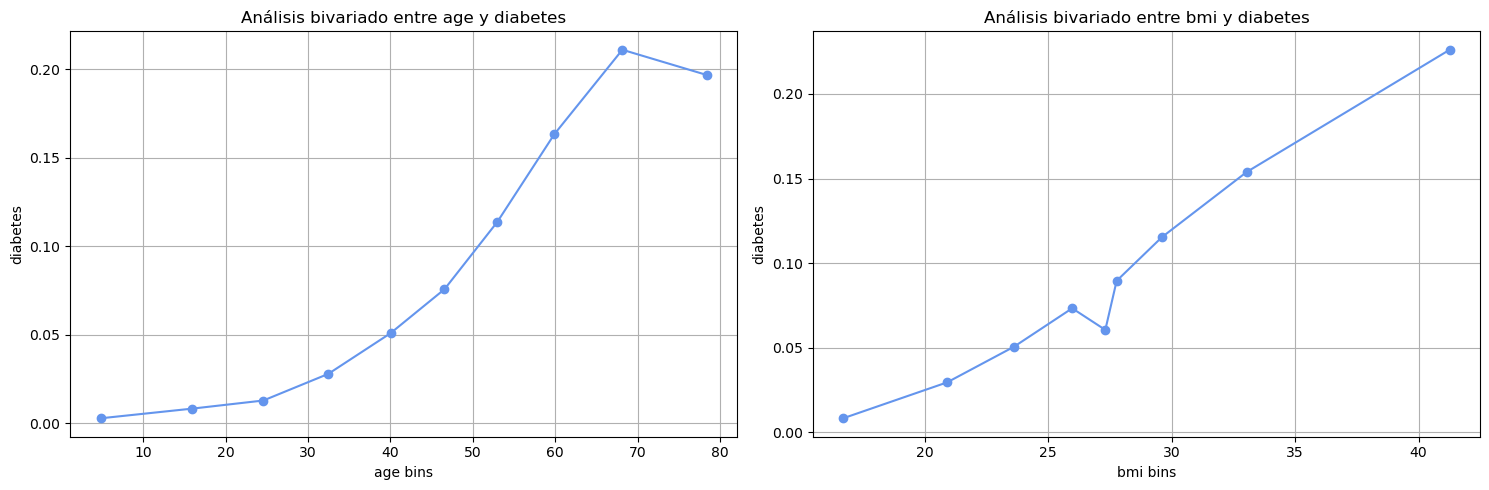

In [5]:
vibariado(data[['age', 'bmi', target]], y)

# Feature engineering

## Dummies

In [6]:
data = pd.get_dummies(data, columns=['gender', 'smoking_history'])

## Transformaciones

In [7]:
data['log_age'] = np.log(data['age'])
data['bmi^2'] = data['bmi'] ** 2

## Nuevas variables

In [8]:
data['age/bmi'] = data['age'] / data['bmi']
data['age*bmi'] = data['age'] * data['bmi']

# Preparación de datos

## Cross validation

In [9]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN clasificador

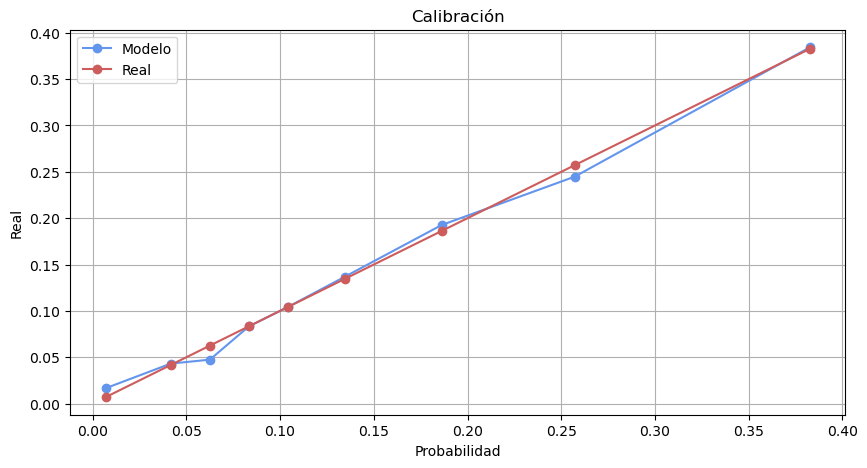

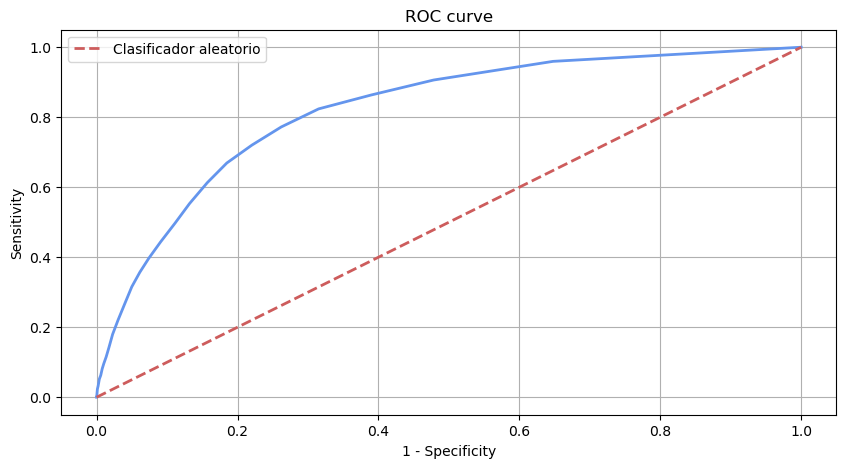

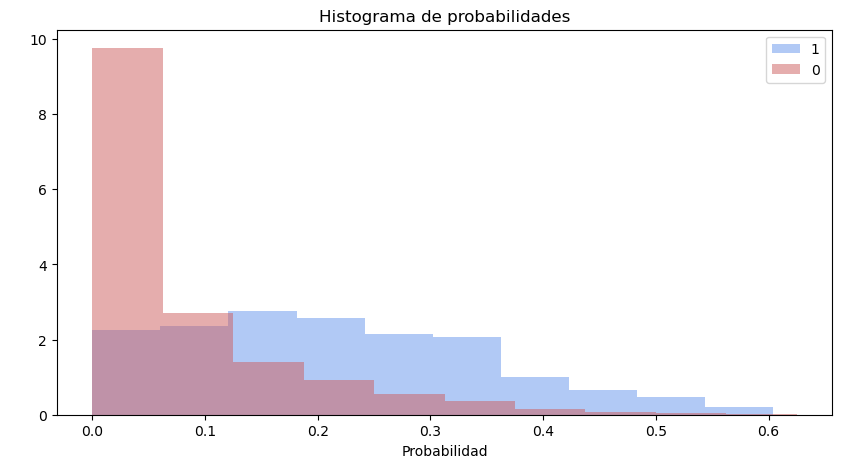

Mejor Modelo: {'logistic__n_neighbors': 48}

Con 48 neighbors:
- AUC: 0.8204
- Gini: 0.6407


In [10]:
knn(X_train, X_test, y_train, y_test, range(1, 50))

# Regresión logística

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

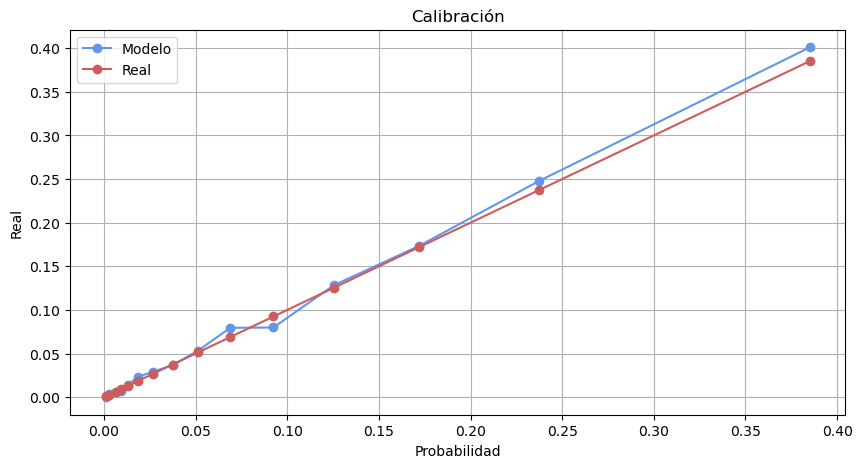

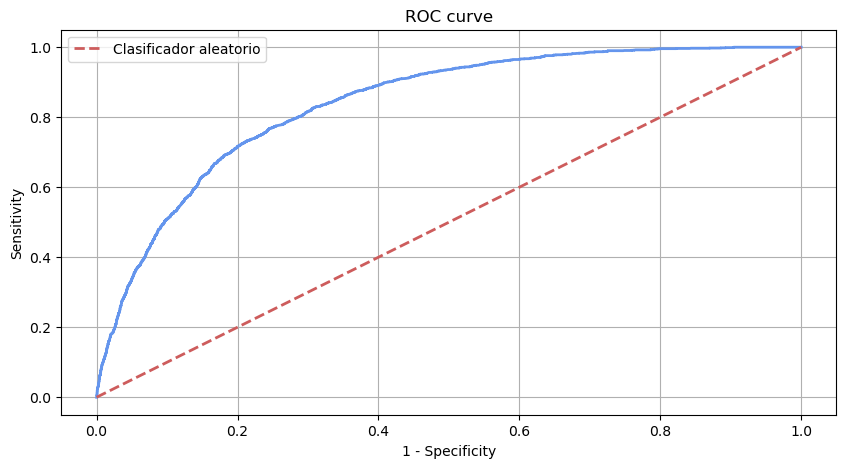

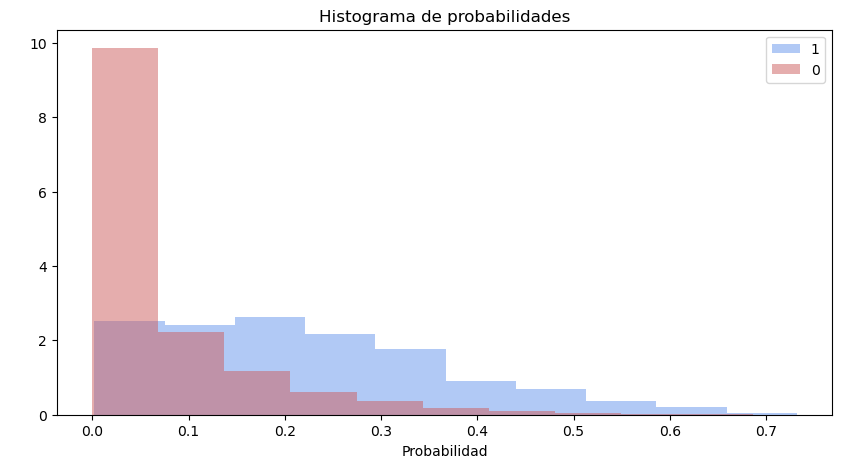

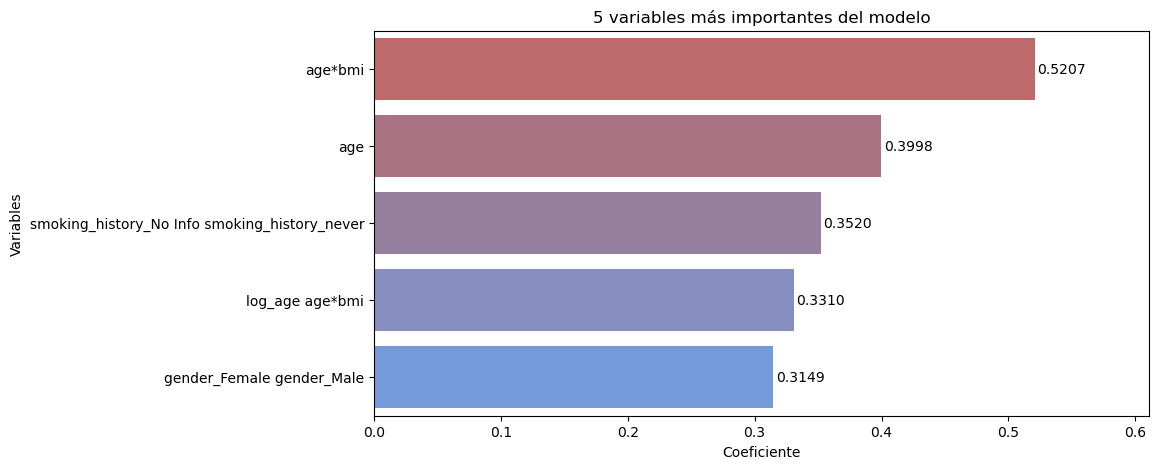

Mejor modelo: {'poly__degree': 2, 'logistic__penalty': None}

AUC: 0.8388
Gini: 0.6776


In [11]:
logistic(X_train, X_test, y_train, y_test)

# Red neuronal

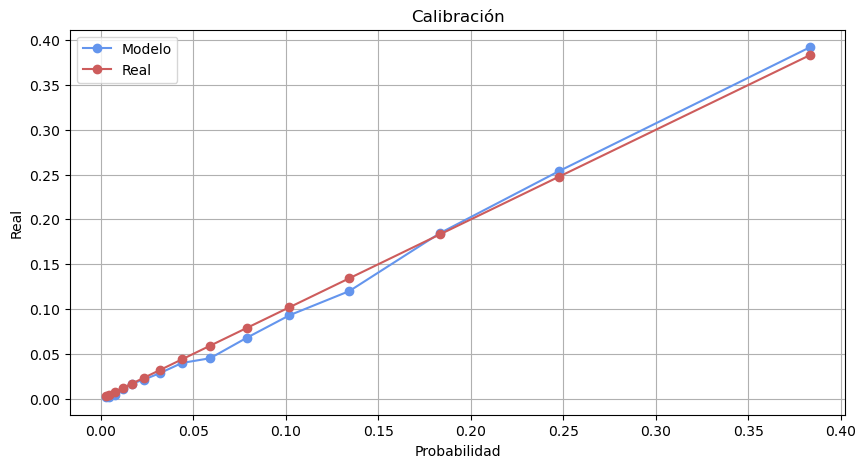

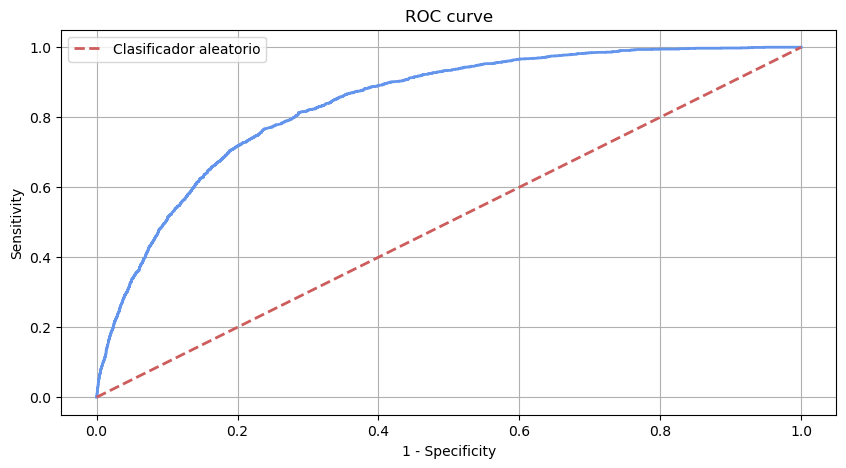

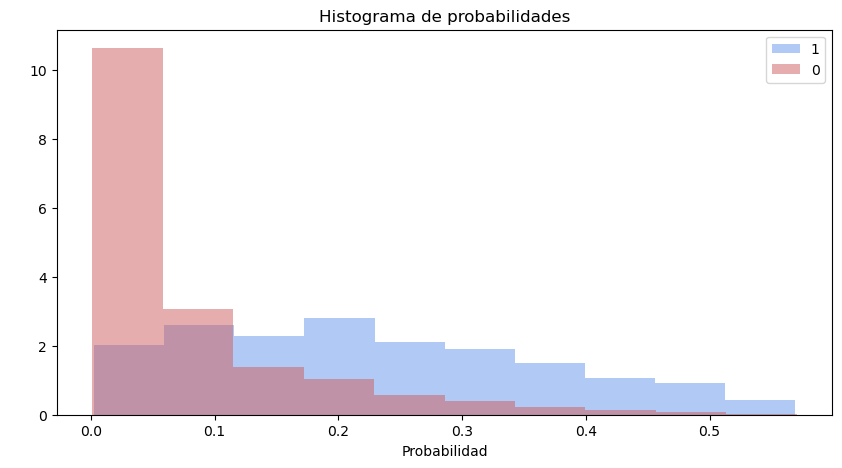

Mejor modelo: {'nn__activation': 'relu', 'nn__alpha': 0.1, 'nn__hidden_layer_sizes': (10, 10, 10), 'poly__degree': 1}

AUC: 0.8387
Gini: 0.6773


In [12]:
neural_network(X_train, X_test, y_train, y_test)

# Discriminante lineal

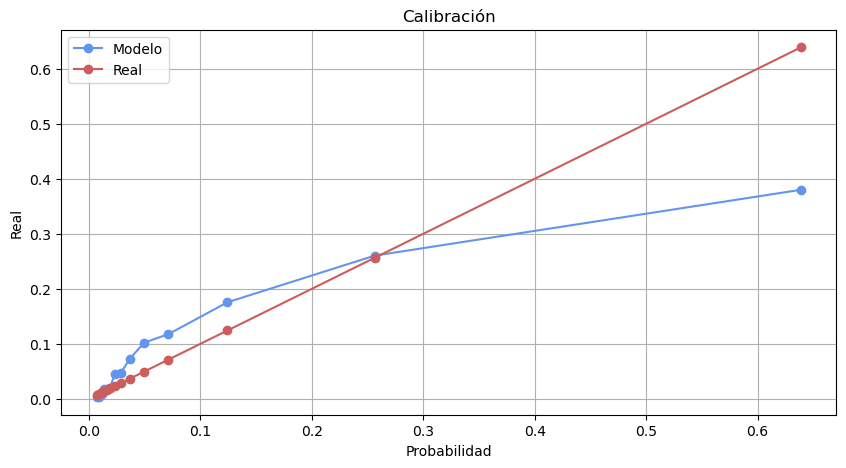

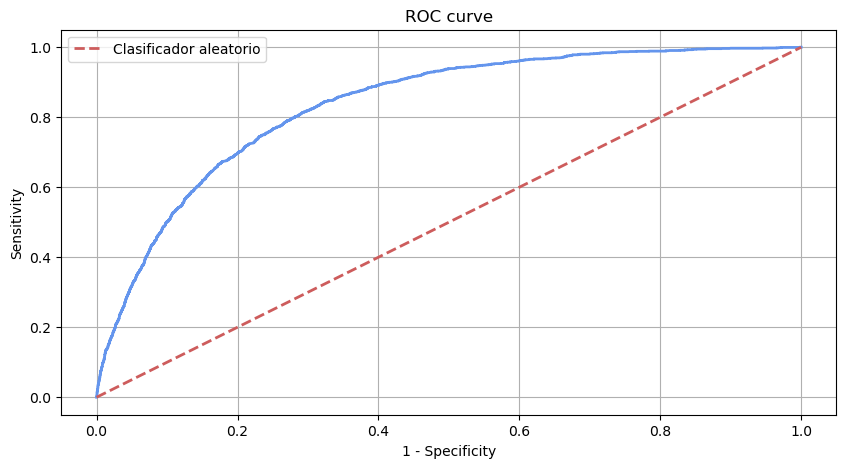

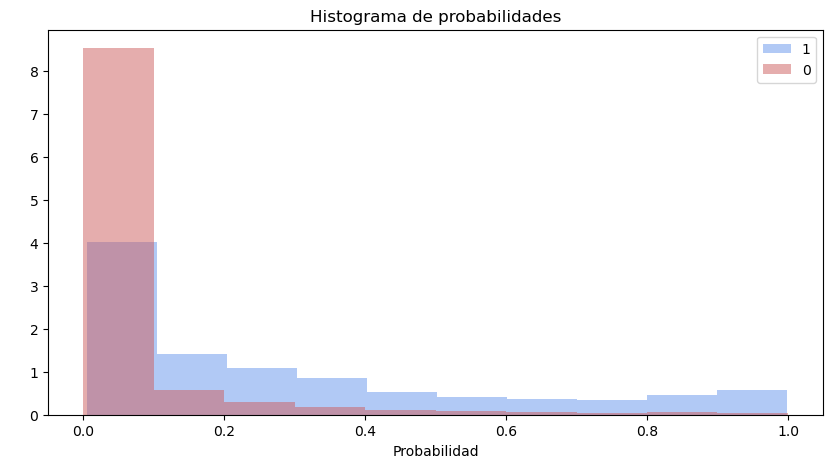

AUC: 0.8348
Gini: 0.6696


In [13]:
discriminant(X_train, X_test, y_train, y_test)

# Conlusiones generales